In [1]:
import warnings
import re
from PIL import Image
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
warnings.filterwarnings('ignore')

C:\Users\agavr\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# display options for pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [3]:
import os

current_directory = os.getcwd()
file_list = os.listdir(current_directory)

print("Files in the Current Directory:")
for file in file_list:
    print(file)


Files in the Current Directory:
.ipynb_checkpoints
genome_scores.csv
genome_tags.csv
link.csv
movie.csv
rating.csv
rectag.ipynb
tag.csv
tags_based_rec.ipynb


In [4]:
# movie titles
mv_title = pd.read_csv('movie.csv')
# movie tags
mv_tags = pd.read_csv('genome_scores.csv')
# movie tag names
mv_tags_names = pd.read_csv('genome_tags.csv')

In [5]:
df = mv_title
df.head(20)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [6]:
df = mv_tags
df.head(10)

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675
5,1,6,0.21700
6,1,7,0.06700
7,1,8,0.26275
8,1,9,0.26200
9,1,10,0.03200


In [7]:
df = mv_tags_names
df.head(10)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
5,6,1950s
6,7,1960s
7,8,1970s
8,9,1980s
9,10,19th century


In [8]:
# number of tags
len(np.unique(mv_tags_names.tagId.values))

1128

In [9]:
# number of movies
len(np.unique(mv_tags.movieId.values))

10381

In [10]:
# number of movie, tag pairs
len(mv_tags)

11709768

In [11]:
# clean title in movies.csv file
def movie_title_clean(title):
  
  # search title for (year) pattern
  s = re.search('\(([^)]+)', title)

  # if pattern exists, remove from string
  year = 9999
  if s:

    title = title[:s.span()[0]].strip()
    year = s.group(1)
  
    # check if year is actual year
    if str(year).isdigit():
      year = int(year)
    else:
      year = 9999  
  
  # if ', The' or ', A' is a the end of the string, move it to the front
  # e.g. change "Illusionist, The" to "The Illusionist"
  if title[-5:] == ', The':
    title = 'The ' + title[:-5]
  elif title[-4:] == ', An':
    title = 'An ' + title[:-4]
  elif title[-3:] == ', A':
    title = 'A ' + title[:-3]
    
  return title, year

In [12]:
# clean title and extract release year
mv_title['title'] = mv_title['title'].str.strip()
mv_title['year'] = mv_title['title'].map(movie_title_clean)
mv_title['title'] = mv_title['year'].apply(lambda x: x[0])
mv_title['Release Year'] = mv_title['year'].apply(lambda x: x[1])

In [13]:
mv_title.head(20)

,movieId,title,genres,year,Release Year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,"(Toy Story, 1995)",1995
1,2,Jumanji,Adventure|Children|Fantasy,"(Jumanji, 1995)",1995
2,3,Grumpier Old Men,Comedy|Romance,"(Grumpier Old Men, 1995)",1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,"(Waiting to Exhale, 1995)",1995
4,5,Father of the Bride Part II,Comedy,"(Father of the Bride Part II, 1995)",1995
5,6,Heat,Action|Crime|Thriller,"(Heat, 1995)",1995
6,7,Sabrina,Comedy|Romance,"(Sabrina, 1995)",1995
7,8,Tom and Huck,Adventure|Children,"(Tom and Huck, 1995)",1995
8,9,Sudden Death,Action,"(Sudden Death, 1995)",1995
9,10,GoldenEye,Action|Adventure|Thriller,"(GoldenEye, 1995)",1995


In [14]:
# Assuming you want to find the movieId for the movie A Beautiful Mind
movie_title_to_find = 'A Beautiful Mind'

# Check if the movie title exists in the DataFrame and get its corresponding movieId
matching_movie = mv_title[mv_title.title == movie_title_to_find]

if not matching_movie.empty:
    movie_id = matching_movie.iloc[0]['movieId']
    print(f"The movieId for '{movie_title_to_find}' is {movie_id}.")
else:
    print(f"'{movie_title_to_find}' not found in the DataFrame.")


The movieId for 'A Beautiful Mind' is 4995.


In [15]:
# join dataframes to get tag description and movie title name all in one table
mv_tags_denorm = mv_tags.merge(mv_tags_names, on = 'tagId').merge(mv_title, on = 'movieId')

# for each movie, compute the relevance rank of tags so we can eventually rank order tags for each movie
mv_tags_denorm['relevance_rank'] = mv_tags_denorm.groupby("movieId")["relevance"].rank(method = "first", ascending = False).astype('int64')

# check out an example of top tags for a movie
df = mv_tags_denorm[mv_tags_denorm.title == 'Toy Story'][['movieId','title','tag','relevance','relevance_rank']].sort_values(by = 'relevance', ascending = False)
df.head(10)

,movieId,title,tag,relevance,relevance_rank
1035,1,Toy Story,toys,0.99925,1
243,1,Toy Story,computer animation,0.99850,2
785,1,Toy Story,pixar animation,0.99600,3
588,1,Toy Story,kids and family,0.99075,4
63,1,Toy Story,animation,0.98575,5
587,1,Toy Story,kids,0.97925,6
784,1,Toy Story,pixar,0.96675,7
203,1,Toy Story,children,0.96425,8
185,1,Toy Story,cartoon,0.95650,9
535,1,Toy Story,imdb top 250,0.94200,10


In [16]:
# flatten tags table to get a list of top 100 tags for each movie
mv_tags_list = mv_tags_denorm[mv_tags_denorm.relevance_rank <= 100].groupby(['movieId','title'])['tag'].apply(lambda x: ','.join(x)).reset_index()
mv_tags_list['tag_list'] = mv_tags_list.tag.map(lambda x: x.split(','))

In [17]:
# compute Jaccard Index to get most similar movies to target movie

pd.reset_option('display.max_colwidth')

target_movie = 'Toy Story'

target_tag_list = mv_tags_list[mv_tags_list.title == target_movie].tag_list.values[0]
mv_tags_list_sim = mv_tags_list[['movieId','title','tag_list','tag']]
mv_tags_list_sim['jaccard_sim'] = mv_tags_list_sim.tag_list.map(lambda x: len(set(x).intersection(set(target_tag_list))) / len(set(x).union(set(target_tag_list))))
print(f'Movies most similar to {target_movie} based on tags:')
text = ','.join(mv_tags_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(25)['tag'].values)
mv_tags_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(10)

Movies most similar to Toy Story based on tags:


,movieId,title,tag_list,tag,jaccard_sim
0,1,Toy Story,"[3d, action, adventure, affectionate, animal m...","3d,action,adventure,affectionate,animal movie,...",1.000000
4331,4886,"Monsters, Inc.","[adventure, affectionate, allegory, alone in t...","adventure,affectionate,allegory,alone in the w...",0.724138
2064,2355,A Bug's Life,"[3d, action, adventure, alter ego, animal movi...","3d,action,adventure,alter ego,animal movie,ani...",0.680672
2769,3114,Toy Story 2,"[action, adventure, animal movie, animals, ani...","action,adventure,animal movie,animals,animated...",0.652893
5445,6377,Finding Nemo,"[adventure, affectionate, animal movie, animal...","adventure,affectionate,animal movie,animals,an...",0.612903
4602,5218,Ice Age,"[3d, action, adventure, animal movie, animals,...","3d,action,adventure,animal movie,animals,anima...",0.612903
7994,50872,Ratatouille,"[allegory, animal movie, animals, animated, an...","allegory,animal movie,animals,animated,animati...",0.574803
7766,45517,Cars,"[action, adventure, alter ego, animal movie, a...","action,adventure,alter ego,animal movie,animal...",0.574803
3809,4306,Shrek,"[adventure, animal movie, animals, animated, a...","adventure,animal movie,animals,animated,animat...",0.550388
554,588,Aladdin,"[action, adventure, affectionate, animal movie...","action,adventure,affectionate,animal movie,ani...",0.550388


In [21]:

# Create a dictionary to map movie IDs to their genres
movie_genre_dict = dict(zip(mv_title['movieId'], mv_title['genres']))

# Function to get genres of similar movies
def get_similar_movie_genres(similar_movies):
    similar_movie_genres = []
    # Get the genres of the first movie in the list
    first_movie_id = similar_movies[0]
    if first_movie_id in movie_genre_dict:
        first_movie_genres = set(movie_genre_dict[first_movie_id].split('|'))
    for movie_id in similar_movies[1:]:
        if movie_id in movie_genre_dict:
            genres = set(movie_genre_dict[movie_id].split('|'))
            # Find the intersection of genres
            common_genres = first_movie_genres.intersection(genres)
            if common_genres:
                similar_movie_genres.append((movie_id, '|'.join(common_genres)))
    return similar_movie_genres

# Get the most similar movies to 'Toy Story' based on tags
similar_movies = mv_tags_list_sim.sort_values(by='jaccard_sim', ascending=False).head(10)['movieId'].tolist()

# Get the genres of similar movies with intersecting genres
similar_movie_genres = get_similar_movie_genres(similar_movies)

# Print the genres of the similar movies with intersecting genres
print("Genres of movies most similar to Toy Story based on tags with intersecting genres:")
for movie_id, genres in similar_movie_genres:
    print(f"Movie ID: {movie_id}, Genres: {genres}")


Genres of movies most similar to Toy Story based on tags with intersecting genres:
Movie ID: 4886, Genres: Animation|Children|Adventure|Comedy|Fantasy
Movie ID: 2355, Genres: Animation|Adventure|Children|Comedy
Movie ID: 3114, Genres: Animation|Children|Adventure|Comedy|Fantasy
Movie ID: 6377, Genres: Animation|Adventure|Children|Comedy
Movie ID: 5218, Genres: Animation|Adventure|Children|Comedy
Movie ID: 50872, Genres: Animation|Children
Movie ID: 45517, Genres: Animation|Children|Comedy
Movie ID: 4306, Genres: Animation|Children|Adventure|Comedy|Fantasy
Movie ID: 588, Genres: Animation|Children|Comedy|Adventure


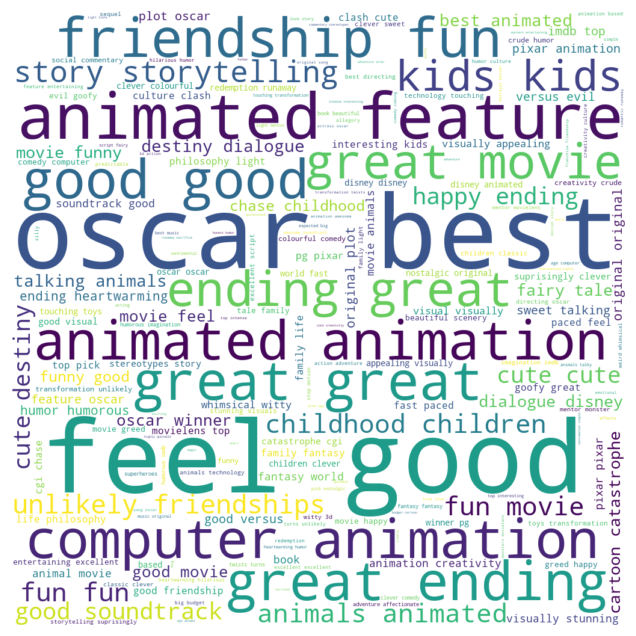

In [22]:
plt.rcParams["figure.figsize"] = (15,10)

# Generate a word cloud image
wordcloud = WordCloud(width = 1024, height = 1024, background_color = 'white').generate(text)

# Display the generated image:
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
# corpus of movie tags
mv_tags_corpus = mv_tags_list.tag.values
stop_words = stopwords.words('english')

# tokenize document and clean
def word_tokenize_clean(doc):
  
  # split into lower case word tokens
  tokens = word_tokenize(doc.lower())
  
  # remove tokens that are not alphabetic (including punctuation) and not a stop word
  tokens = [word for word in tokens if word.isalpha() and not word in stop_words]
  
  return tokens

# preprocess corpus of movie tags before feeding it into Doc2Vec model
mv_tags_doc = [TaggedDocument(words=word_tokenize_clean(D), tags=[str(i)]) for i, D in enumerate(mv_tags_corpus)]

In [24]:
# instantiate Doc2Vec model

max_epochs = 50
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm=0) # paragraph vector distributed bag-of-words (PV-DBOW)
  
model.build_vocab(mv_tags_doc)

In [25]:
# train Doc2Vec model

print('Epoch', end = ': ')
for epoch in range(max_epochs):
  print(epoch, end = ' ')
  model.train(mv_tags_doc,
              total_examples=model.corpus_count,
              epochs=model.epochs)
  # decrease the learning rate
  model.alpha -= 0.0002
  # fix the learning rate, no decay
  model.min_alpha = model.alpha

Epoch: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [26]:
# List the document vectors
mv_tags_vectors = model.dv.vectors
mv_tags_vectors.shape

(10381, 20)

In [27]:
# top similar movies based on cosine similarity

mv = 'Toy Story'

mv_index = mv_tags_list[mv_tags_list["title"] == mv].index.values[0]

print(mv_tags_vectors[mv_index])

sims = model.docvecs.most_similar(positive = [mv_index], topn = 30)

for i, j in sims:
  print(mv_tags_list.loc[int(i), "title"].strip())

[ 0.12913053  1.2489676   0.21413566  1.2554644   0.6497219   0.42906547
 -0.51371527  0.3801461  -1.1437228  -0.6043959  -2.4747212  -0.4150552
 -1.4436477  -0.53858125 -0.70012164 -0.2461364   0.7729745  -0.54395384
 -0.06814313  0.30975366]
Monsters, Inc.
Lifted
Toy Story of Terror
Luxo Jr.
Toy Story That Time Forgot
Partly Cloudy
Mike's New Car
Toy Story 2
BURN-E
Wreck-It Ralph
The Many Adventures of Winnie the Pooh
The Lego Movie
Tin Toy
Day & Night
It's the Great Pumpkin, Charlie Brown
Winnie the Pooh and the Blustery Day
Toy Story 3
One Man Band
Jack-Jack Attack
Wallace & Gromit in The Curse of the Were-Rabbit
The Boxtrolls
Rise of the Guardians
The Iron Giant
Up
How to Train Your Dragon
Paperman
Antz
How the Grinch Stole Christmas!
Ice Age
Raiders of the Lost Ark: The Adaptation


In [28]:
# dimensionality reduction to 2D
mv_tags_vectors_umap = umap.UMAP(n_neighbors = 5,
                          min_dist = 0.001,
                          metric = 'cosine').fit_transform(mv_tags_vectors)
x, y = mv_tags_vectors_umap.T[0], mv_tags_vectors_umap.T[1]

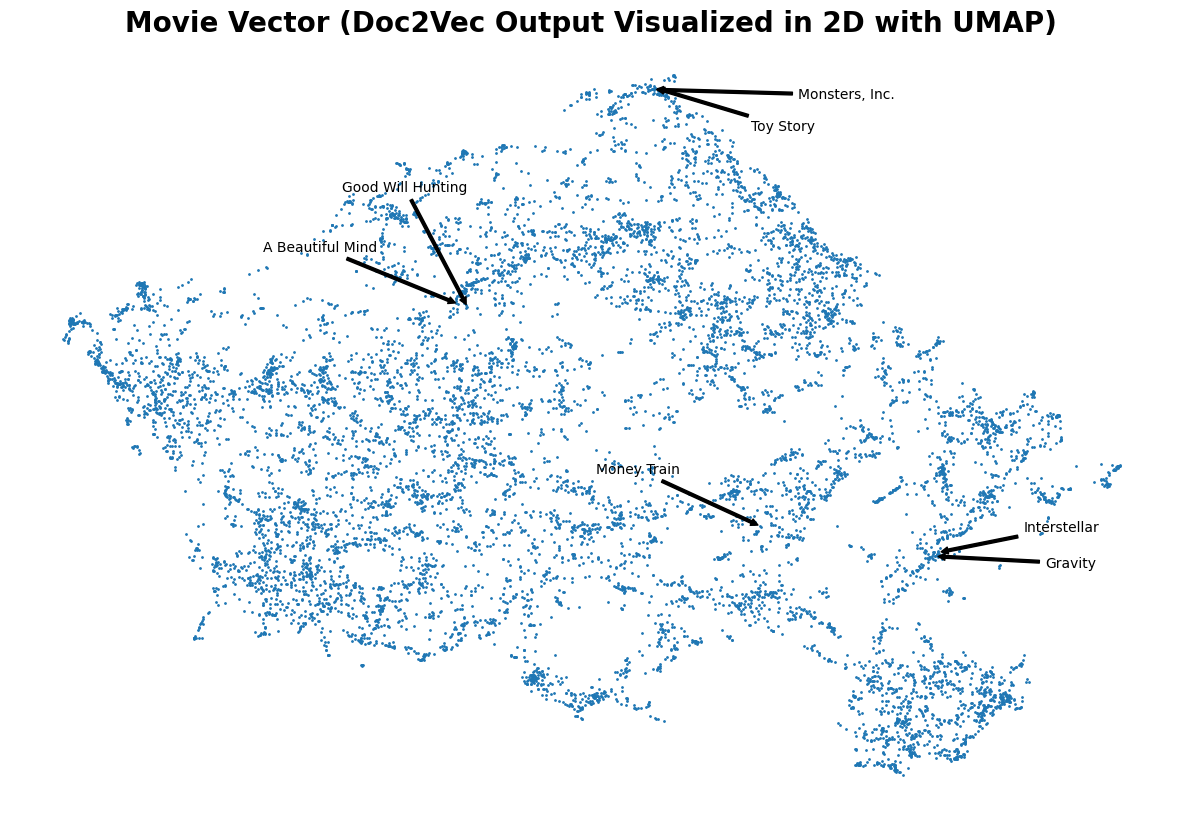

In [29]:
# visualize movie vectors in 2D with UMAP
# feel free to label any movies for representation

plt.rcParams["figure.figsize"] = (15,10)
plt.grid(b = None)
plt.axis('off')
plt.scatter(x, y, s = 1)
plt.title('Document Embedding (UMAP)')
plt.xlabel('e1')
plt.ylabel('e2')

mv = 'Money Train'
mv_index = mv_tags_list[mv_tags_list["title"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]-1, mv_tags_vectors_umap[mv_index, 1]+1),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'A Beautiful Mind'
mv_index = mv_tags_list[mv_tags_list["title"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]-1, mv_tags_vectors_umap[mv_index, 1]+1),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'Good Will Hunting'
mv_index = mv_tags_list[mv_tags_list["title"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]+2),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'Gravity'
mv_index = mv_tags_list[mv_tags_list["title"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]+2, mv_tags_vectors_umap[mv_index, 1]),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'Interstellar'
mv_index = mv_tags_list[mv_tags_list["title"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]+2, mv_tags_vectors_umap[mv_index, 1]+0.5),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'Toy Story'
mv_index = mv_tags_list[mv_tags_list["title"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]+2, mv_tags_vectors_umap[mv_index, 1]-0.5),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'Monsters, Inc.'
mv_index = mv_tags_list[mv_tags_list["title"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]+3, mv_tags_vectors_umap[mv_index, 1]+0.025),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

plt.title('Movie Vector (Doc2Vec Output Visualized in 2D with UMAP)', fontsize = 20, weight = 'bold')
plt.show()

In [30]:
# history of movies the user watched and liked
user_movies = ['Money Train', 'Good Will Hunting', 'Gravity', 'Interstellar', 'Toy Story', 'Monsters, Inc.']

# compute user vector as an average of movie vectors seen by that user
user_movie_vector = np.zeros(shape = mv_tags_vectors.shape[1])
for mv in user_movies:
  mv_index = mv_tags_list[mv_tags_list["title"] == mv].index.values[0]  
  user_movie_vector += mv_tags_vectors[mv_index]

user_movie_vector /= len(user_movies)  

# print(user_movie_vector)
  
#  find movies similar to user vector to generate movie recommendations

print('Movie Recommendations:')

sims = model.docvecs.most_similar(positive = [user_movie_vector], topn = 30)

for i, j in sims:
  movie_sim = mv_tags_list.loc[int(i), "title"].strip()
  if movie_sim not in user_movies:
    print(movie_sim)

Movie Recommendations:
Cast Away
Close Encounters of the Third Kind
Lifted
The Curious Case of Benjamin Button
Star Trek: First Contact
E.T. the Extra-Terrestrial
Rush
The Artist
Starman
Gattaca
Independence Day
Contact
WALL·E
*batteries not included
The Right Stuff
The Theory of Everything
The World's Fastest Indian
Toy Story 3
Star Wars: Episode IV - A New Hope
Aliens of the Deep
The Secret Life of Walter Mitty
Back to the Future
Phenomenon
Real Steel
Toy Story 2
Inception


In [41]:
from collections import Counter

# History of movies the user watched and liked
user_movies = ['Money Train', 'Good Will Hunting', 'Gravity', 'Interstellar', 'Toy Story', 'Monsters, Inc']

# Create a dictionary to map movies to their genres
movie_to_genres = {}
for index, row in mv_tags_list.iterrows():
    movie_to_genres[row['title']] = set(mv_title[mv_title['movieId'] == row['movieId']]['genres'].values[0].split('|'))

# Create a list of all genres in the user's watchlist
user_watchlist_genres = []
for mv in user_movies:
    if mv in movie_to_genres:
        genres = movie_to_genres[mv]
        user_watchlist_genres.extend(genres)
        print(f"{mv} (Genres: {' | '.join(genres)})")

# Count the frequency of each genre in the user's watchlist
genre_counts = Counter(user_watchlist_genres)

# Create a set of unique genres for accurate counting
unique_genres = set(user_watchlist_genres)

# Sort genres by frequency in descending order
sorted_genres = sorted(unique_genres, key=lambda genre: genre_counts[genre], reverse=True)

# Print genres in descending order of frequency
print('\nGenres in User\'s Watchlist by Frequency (Descending Order):')
for genre in sorted_genres:
    count = genre_counts[genre]
    print(f"{genre}: {count}")

# Compute user vector as an average of movie vectors seen by that user
user_movie_vector = np.zeros(shape=mv_tags_vectors.shape[1])
for mv in user_movies:
    if mv in movie_to_genres:
        mv_genres = movie_to_genres[mv]
        mv_index = mv_tags_list[mv_tags_list["title"] == mv].index.values
        if len(mv_index) > 0:
            mv_index = mv_index[0]
            user_movie_vector += mv_tags_vectors[mv_index]

user_movie_vector /= len(user_movies)

# Find movies similar to user vector to generate movie recommendations
print('\nMovie Recommendations with Intersecting Genres:')
sims = model.docvecs.most_similar(positive=[user_movie_vector], topn=0)
for i, j in sims:
    movie_sim = mv_tags_list.loc[int(i), "title"].strip()
    if movie_sim not in user_movies:
        mv_index = mv_tags_list[mv_tags_list["title"] == movie_sim].index.values
        if len(mv_index) > 0:
            mv_index = mv_index[0]
            if mv_index in mv_tags_list.index:
                movie_genres = movie_to_genres.get(movie_sim, set())
                intersecting_genres = set(user_watchlist_genres).intersection(movie_genres)
                if intersecting_genres:
                    print(f"{movie_sim} (Genres: {' | '.join(intersecting_genres)})")


Money Train (Genres: Action | Thriller | Comedy | Drama | Crime)
Good Will Hunting (Genres: Drama | Romance)
Gravity (Genres: Action | Sci-Fi | IMAX)
Interstellar (Genres: Sci-Fi | IMAX)
Toy Story (Genres: Animation | Children | Adventure | Comedy | Fantasy)

Genres in User's Watchlist by Frequency (Descending Order):
Action: 2
Sci-Fi: 2
IMAX: 2
Comedy: 2
Drama: 2
Thriller: 1
Animation: 1
Children: 1
Adventure: 1
Fantasy: 1
Crime: 1
Romance: 1

Movie Recommendations with Intersecting Genres:
Cast Away (Genres: Drama)
Close Encounters of the Third Kind (Genres: Adventure | Sci-Fi | Drama)
Gattaca (Genres: Thriller | Sci-Fi | Drama)
Star Trek: First Contact (Genres: Action | Adventure | Sci-Fi | Thriller)
Rush (Genres: Action | Drama)
The Curious Case of Benjamin Button (Genres: Fantasy | Drama | Romance)
Contact (Genres: Sci-Fi | Drama)
The Theory of Everything (Genres: Drama | Romance)


In [65]:
from collections import Counter

# History of movies the user watched and liked
user_movies = ['Money Train', 'Good Will Hunting', 'Gravity', 'Interstellar', 'Toy Story', 'Monsters, Inc']

# Create a dictionary to map movies to their genres
movie_to_genres = {}
for index, row in mv_tags_list.iterrows():
    movie_to_genres[row['title']] = set(mv_title[mv_title['movieId'] == row['movieId']]['genres'].values[0].split('|'))

# Create a list of all genres in the user's watchlist
user_watchlist_genres = []
for mv in user_movies:
    if mv in movie_to_genres:
        genres = movie_to_genres[mv]
        user_watchlist_genres.extend(genres)
        print(f"{mv} (Genres: {' | '.join(genres)}")

# Count the frequency of each genre in the user's watchlist
genre_counts = Counter(user_watchlist_genres)

# Create a set of unique genres for accurate counting
unique_genres = set(user_watchlist_genres)

# Sort genres by frequency in descending order
sorted_genres = sorted(unique_genres, key=lambda genre: genre_counts[genre], reverse=True)

# Print genres in descending order of frequency
print('\nGenres in User\'s Watchlist by Frequency (Descending Order):')
for genre in sorted_genres:
    count = genre_counts[genre]
    print(f"{genre}: {count}")

# Compute user vector as an average of movie vectors seen by that user
user_movie_vector = np.zeros(shape=mv_tags_vectors.shape[1])
for mv in user_movies:
    if mv in movie_to_genres:
        mv_genres = movie_to_genres[mv]
        mv_index = mv_tags_list[mv_tags_list["title"] == mv].index.values
        if len(mv_index) > 0:
            mv_index = mv_index[0]
            user_movie_vector += mv_tags_vectors[mv_index]

user_movie_vector /= len(user_movies)

# Find movies similar to user vector to generate movie recommendations
print('\nMovie Recommendations with Intersecting Genres:')
sims = model.docvecs.most_similar(positive=[user_movie_vector], topn=10)  # Change topn to 10
for i, j in sims:
    movie_sim = mv_tags_list.loc[int(i), "title"].strip()
    if movie_sim not in user_movies:
        mv_index = mv_tags_list[mv_tags_list["title"] == movie_sim].index.values
        if len(mv_index) > 0:
            mv_index = mv_index[0]
            if mv_index in mv_tags_list.index:
                movie_genres = movie_to_genres.get(movie_sim, set())
                intersecting_genres = set(user_watchlist_genres).intersection(movie_genres)
                if intersecting_genres:
                    movie_id = mv_tags_list.loc[int(i), "movieId"]
                    print(f"{movie_sim} (Genres: {' | '.join(intersecting_genres)})")
                    print(f"Movie ID: {movie_id}")


Money Train (Genres: Action | Thriller | Comedy | Drama | Crime
Good Will Hunting (Genres: Drama | Romance
Gravity (Genres: Action | Sci-Fi | IMAX
Interstellar (Genres: Sci-Fi | IMAX
Toy Story (Genres: Animation | Children | Adventure | Comedy | Fantasy

Genres in User's Watchlist by Frequency (Descending Order):
Action: 2
Sci-Fi: 2
IMAX: 2
Comedy: 2
Drama: 2
Thriller: 1
Animation: 1
Children: 1
Adventure: 1
Fantasy: 1
Crime: 1
Romance: 1

Movie Recommendations with Intersecting Genres:
Cast Away (Genres: Drama)
Movie ID: 4022
Close Encounters of the Third Kind (Genres: Adventure | Sci-Fi | Drama)
Movie ID: 3471
Gattaca (Genres: Thriller | Sci-Fi | Drama)
Movie ID: 1653
Star Trek: First Contact (Genres: Action | Adventure | Sci-Fi | Thriller)
Movie ID: 1356
Rush (Genres: Action | Drama)
Movie ID: 104913
The Curious Case of Benjamin Button (Genres: Fantasy | Drama | Romance)
Movie ID: 64957
Contact (Genres: Sci-Fi | Drama)
Movie ID: 1584
The Theory of Everything (Genres: Drama | Romance

In [67]:
from collections import Counter

# History of movies the user watched and liked
user_movies = ['Money Train', 'Good Will Hunting', 'Gravity', 'Interstellar', 'Toy Story', 'Monsters, Inc']

# Create a dictionary to map movies to their genres
movie_to_genres = {}
for index, row in mv_tags_list.iterrows():
    movie_to_genres[row['title']] = set(mv_title[mv_title['movieId'] == row['movieId']]['genres'].values[0].split('|'))

# Create a list of all genres in the user's watchlist
user_watchlist_genres = []
for mv in user_movies:
    if mv in movie_to_genres:
        genres = movie_to_genres[mv]
        user_watchlist_genres.extend(genres)
        print(f"{mv} (Genres: {' | '.join(genres)})")

# Count the frequency of each genre in the user's watchlist
genre_counts = Counter(user_watchlist_genres)

# Create a set of unique genres for accurate counting
unique_genres = set(user_watchlist_genres)

# Sort genres by frequency in descending order
sorted_genres = sorted(unique_genres, key=lambda genre: genre_counts[genre], reverse=True)

# Print genres in descending order of frequency
print('\nGenres in User\'s Watchlist by Frequency (Descending Order):')
for genre in sorted_genres:
    count = genre_counts[genre]
    print(f"{genre}: {count}")

# Compute user vector as an average of movie vectors seen by that user
user_movie_vector = np.zeros(shape=mv_tags_vectors.shape[1])
for mv in user_movies:
    if mv in movie_to_genres:
        mv_genres = movie_to_genres[mv]
        mv_index = mv_tags_list[mv_tags_list["title"] == mv].index.values
        if len(mv_index) > 0:
            mv_index = mv_index[0]
            user_movie_vector += mv_tags_vectors[mv_index]

user_movie_vector /= len(user_movies)

# Find movies similar to user vector to generate movie recommendations
print('\nMovie Recommendations with Intersecting Genres:')
sims = model.docvecs.most_similar(positive=[user_movie_vector], topn=10)
for i, j in sims:
    movie_sim = mv_tags_list.loc[int(i), "title"].strip()
    if movie_sim not in user_movies:
        mv_index = mv_tags_list[mv_tags_list["title"] == movie_sim].index.values
        if len(mv_index) > 0:
            mv_index = mv_index[0]
            if mv_index in mv_tags_list.index:
                movie_genres = movie_to_genres.get(movie_sim, set())
                intersecting_genres = set(user_watchlist_genres).intersection(movie_genres)
                if intersecting_genres:
                    movie_id = mv_tags_list.loc[int(i), "movieId"]
                    print(f"{movie_sim} is of Genre: {' | '.join(intersecting_genres)} with a Movie ID: {movie_id}")
                    # Print the first recommended movie and its genre
                    first_recommendation = movie_sim
                    first_recommendation_genre = ', '.join(intersecting_genres)
                    print(f"The movie '{first_recommendation}' was recommended for you because '{first_recommendation_genre}' is the most watched genre.")
                    break  # Stop after the first recommendation
                    #add return method {movieid, genre}


Money Train (Genres: Action | Thriller | Comedy | Drama | Crime)
Good Will Hunting (Genres: Drama | Romance)
Gravity (Genres: Action | Sci-Fi | IMAX)
Interstellar (Genres: Sci-Fi | IMAX)
Toy Story (Genres: Animation | Children | Adventure | Comedy | Fantasy)

Genres in User's Watchlist by Frequency (Descending Order):
Action: 2
Sci-Fi: 2
IMAX: 2
Comedy: 2
Drama: 2
Thriller: 1
Animation: 1
Children: 1
Adventure: 1
Fantasy: 1
Crime: 1
Romance: 1

Movie Recommendations with Intersecting Genres:
Cast Away is of Genre: Drama with a Movie ID: 4022
The movie 'Cast Away' was recommended for you because 'Drama' is the most watched genre.


In [70]:
from collections import Counter

# History of movies the user watched and liked
user_movies = ['Money Train', 'Good Will Hunting', 'Gravity', 'Interstellar', 'Toy Story', 'Monsters, Inc']

# Create a dictionary to map movies to their genres
movie_to_genres = {}
for index, row in mv_tags_list.iterrows():
    movie_to_genres[row['title']] = set(mv_title[mv_title['movieId'] == row['movieId']]['genres'].values[0].split('|'))

# Create a list of all genres in the user's watchlist
user_watchlist_genres = []
for mv in user_movies:
    if mv in movie_to_genres:
        genres = movie_to_genres[mv]
        user_watchlist_genres.extend(genres)
        print(f"{mv} (Genres: {' | '.join(genres)})")

# Count the frequency of each genre in the user's watchlist
genre_counts = Counter(user_watchlist_genres)

# Create a set of unique genres for accurate counting
unique_genres = set(user_watchlist_genres)

# Sort genres by frequency in descending order
sorted_genres = sorted(unique_genres, key=lambda genre: genre_counts[genre], reverse=True)

# Print genres in descending order of frequency
print('\nGenres in User\'s Watchlist by Frequency (Descending Order):')
for genre in sorted_genres:
    count = genre_counts[genre]
    print(f"{genre}: {count}")

# Compute user vector as an average of movie vectors seen by that user
user_movie_vector = np.zeros(shape=mv_tags_vectors.shape[1])
for mv in user_movies:
    if mv in movie_to_genres:
        mv_genres = movie_to_genres[mv]
        mv_index = mv_tags_list[mv_tags_list["title"] == mv].index.values
        if len(mv_index) > 0:
            mv_index = mv_index[0]
            user_movie_vector += mv_tags_vectors[mv_index]

user_movie_vector /= len(user_movies)

# Find movies similar to user vector to generate movie recommendations
print('\nMovie Recommendations with Intersecting Genres:')
recommendations = []
sims = model.docvecs.most_similar(positive=[user_movie_vector], topn=10)
for i, j in sims:
    movie_sim = mv_tags_list.loc[int(i), "title"].strip()
    if movie_sim not in user_movies:
        mv_index = mv_tags_list[mv_tags_list["title"] == movie_sim].index.values
        if len(mv_index) > 0:
            mv_index = mv_index[0]
            if mv_index in mv_tags_list.index:
                movie_genres = movie_to_genres.get(movie_sim, set())
                intersecting_genres = set(user_watchlist_genres).intersection(movie_genres)
                if intersecting_genres:
                    movie_id = mv_tags_list.loc[int(i), "movieId"]
                    recommendations.append({"movieId": movie_id, "genre": ', '.join(intersecting_genres)})
                    print(f"{movie_sim} is of Genre: {' | '.join(intersecting_genres)} with a Movie ID: {movie_id}")

# Print the first recommended movie and its genre
if recommendations:
    first_recommendation = recommendations[0]
    print(f"The movie '{first_recommendation['movieId']}' was recommended for you because '{first_recommendation['genre']}' is the most watched genre.")

# Return the list of recommendations
recommendations


Money Train (Genres: Action | Thriller | Comedy | Drama | Crime)
Good Will Hunting (Genres: Drama | Romance)
Gravity (Genres: Action | Sci-Fi | IMAX)
Interstellar (Genres: Sci-Fi | IMAX)
Toy Story (Genres: Animation | Children | Adventure | Comedy | Fantasy)

Genres in User's Watchlist by Frequency (Descending Order):
Action: 2
Sci-Fi: 2
IMAX: 2
Comedy: 2
Drama: 2
Thriller: 1
Animation: 1
Children: 1
Adventure: 1
Fantasy: 1
Crime: 1
Romance: 1

Movie Recommendations with Intersecting Genres:
Cast Away is of Genre: Drama with a Movie ID: 4022
Close Encounters of the Third Kind is of Genre: Adventure | Sci-Fi | Drama with a Movie ID: 3471
Gattaca is of Genre: Thriller | Sci-Fi | Drama with a Movie ID: 1653
Star Trek: First Contact is of Genre: Action | Adventure | Sci-Fi | Thriller with a Movie ID: 1356
Rush is of Genre: Action | Drama with a Movie ID: 104913
The Curious Case of Benjamin Button is of Genre: Fantasy | Drama | Romance with a Movie ID: 64957
Contact is of Genre: Sci-Fi | Dr

[{'movieId': 4022, 'genre': 'Drama'},
 {'movieId': 3471, 'genre': 'Adventure, Sci-Fi, Drama'},
 {'movieId': 1653, 'genre': 'Thriller, Sci-Fi, Drama'},
 {'movieId': 1356, 'genre': 'Action, Adventure, Sci-Fi, Thriller'},
 {'movieId': 104913, 'genre': 'Action, Drama'},
 {'movieId': 64957, 'genre': 'Fantasy, Drama, Romance'},
 {'movieId': 1584, 'genre': 'Sci-Fi, Drama'},
 {'movieId': 117176, 'genre': 'Drama, Romance'}]